In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers

In [2]:
# ==== 1. Hyperparameter
CSV_PATH      = "binance_data_merged/BTCUSDT.csv"
TEST_RATIO    = 0.2
SEQ_LEN       = 258    
FORECAST_DAYS = 2     
CV_SPLITS     = 10
LR            = 1e-3   
BATCH_SIZE    = 128
EPOCHS        = 300
DROP_RATE     = 0.4
UNITS_1       = 528
UNITS_2       = 256

In [3]:
df_raw = pd.read_csv(
    CSV_PATH,
    parse_dates=['open_time'],
    index_col='open_time'
).ffill()

In [4]:
print("Jumlah missing value per kolom (sebelum imputasi):")
print(df_raw.isna().sum())

Jumlah missing value per kolom (sebelum imputasi):
open                             0
high                             0
low                              0
close                            0
volume                           0
close_time                       0
quote_asset_volume               0
num_trades                       0
taker_buy_base_asset_volume      0
taker_buy_quote_asset_volume     0
SMA_10                           9
SMA_20                          19
EMA_10                           0
EMA_20                           0
MACD                             0
MACD_Signal                      0
RSI_14                          13
Bollinger_Middle                19
Bollinger_Upper                 19
Bollinger_Lower                 19
ATR_14                          13
OBV                              0
CCI_20                          19
Stoch_%K                        13
Stoch_%D                        15
MFI_14                          13
ROC_10                          10
Mome

In [5]:
df_raw = df_raw.interpolate(method='linear', limit_direction='both').ffill().bfill()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_37984\2364777914.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_raw = df_raw.interpolate(method='linear', limit_direction='both').ffill().bfill()


In [6]:
if df_raw.isna().any().any():
    print("⚠️ Masih ada NA!")
else:
    print("sudah tidak ada NA")

sudah tidak ada NA


In [7]:
BEST_FEATURES = [
    'close', 'volume', 'SMA_10', 'EMA_10', 'MACD', 'RSI_14', 'ATR_14', 'OBV', 'Pct_Change'
]
print("Fitur yang dipakai:", BEST_FEATURES)

Fitur yang dipakai: ['close', 'volume', 'SMA_10', 'EMA_10', 'MACD', 'RSI_14', 'ATR_14', 'OBV', 'Pct_Change']


In [8]:
n_test    = int(len(df_raw) * TEST_RATIO)
train_raw = df_raw.iloc[:-n_test].copy()
test_raw  = df_raw.iloc[-n_test:].copy()

In [9]:
scaler = MinMaxScaler()
train_vals = scaler.fit_transform(train_raw[BEST_FEATURES])
test_vals  = scaler.transform(test_raw[BEST_FEATURES])
joblib.dump(scaler, "scaler_btc_best.save")

interval = pd.infer_freq(df_raw.index) or (df_raw.index[1] - df_raw.index[0])
interval = pd.Timedelta(interval)
horizon  = int(np.ceil(pd.Timedelta(f"{FORECAST_DAYS}D") / interval))
print(f"Interval {interval}, Horizon steps {horizon}")

def make_seq(vals, seq_len, h):
    X, y = [], []
    for i in range(len(vals) - seq_len - h + 1):
        X.append(vals[i:i+seq_len])
        y.append(vals[i+seq_len:i+seq_len+h, BEST_FEATURES.index('close')])
    return np.array(X), np.array(y)

X_tr, y_tr = make_seq(train_vals, SEQ_LEN, horizon)
X_te, y_te = make_seq(test_vals,  SEQ_LEN, horizon)
print(f"X_tr:{X_tr.shape}, y_tr:{y_tr.shape}; X_te:{X_te.shape}, y_te:{y_te.shape}")

Interval 0 days 04:00:00, Horizon steps 12
X_tr:(13407, 258, 9), y_tr:(13407, 12); X_te:(3150, 258, 9), y_te:(3150, 12)


In [10]:
def build_model(seq_len, n_feat, horizon):
    inp = Input(shape=(seq_len, n_feat))
    x = Bidirectional(LSTM(UNITS_1, return_sequences=True, kernel_regularizer=regularizers.l2(1e-5)))(inp)
    x = Dropout(DROP_RATE)(x)
    x = LSTM(UNITS_2, kernel_regularizer=regularizers.l2(1e-5))(x)
    x = Dropout(DROP_RATE)(x)
    out = Dense(horizon)(x)
    model = Model(inp, out)
    model.compile(optimizer=Adam(LR), loss='mse')
    return model

In [11]:
rmse_cv, mae_cv, mse_cv = [], [], []
best_models = []
tscv = TimeSeriesSplit(n_splits=CV_SPLITS)
for fold, (i_tr, i_val) in enumerate(tscv.split(X_tr), 1):
    xtr, xval = X_tr[i_tr], X_tr[i_val]
    ytr, yval = y_tr[i_tr], y_tr[i_val]
    model = build_model(SEQ_LEN, len(BEST_FEATURES), horizon)
    es  = EarlyStopping('val_loss', patience=12, restore_best_weights=True)
    rlr = ReduceLROnPlateau('val_loss', factor=0.5, patience=6, min_lr=1e-5)
    model.fit(
        xtr, ytr,
        validation_data=(xval, yval),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es, rlr],
        verbose=2
    )
    best_models.append(model)
    yv = model.predict(xval)
    mse_vals  = [mean_squared_error(yval[:,h], yv[:,h]) for h in range(horizon)]
    rmse_vals = [np.sqrt(m) for m in mse_vals]
    mae_vals  = [mean_absolute_error(yval[:,h], yv[:,h]) for h in range(horizon)]
    rmse_cv.append(rmse_vals)
    mae_cv.append(mae_vals)
    mse_cv.append(mse_vals)
    print(f"\nFold {fold} metrics:")
    for h in range(horizon):
        print(f" Step t+{h+1}: MSE={mse_vals[h]:.4e}, RMSE={rmse_vals[h]:.4f}, MAE={mae_vals[h]:.4f}")
        plt.figure(figsize=(6,3))
        plt.plot(yval[:,h], label='True')
        plt.plot(yv[:,h], label='Pred')
        plt.title(f'Fold {fold} — Step {h+1}')
        plt.legend(); plt.tight_layout()
        plt.savefig(f'fold{fold}_step{h+1}_bestf.png'); plt.close()

Epoch 1/300
10/10 - 27s - 3s/step - loss: 0.0178 - val_loss: 0.0107 - learning_rate: 1.0000e-03
Epoch 2/300
10/10 - 23s - 2s/step - loss: 0.0108 - val_loss: 0.0086 - learning_rate: 1.0000e-03
Epoch 3/300
10/10 - 23s - 2s/step - loss: 0.0088 - val_loss: 0.0074 - learning_rate: 1.0000e-03
Epoch 4/300
10/10 - 24s - 2s/step - loss: 0.0074 - val_loss: 0.0061 - learning_rate: 1.0000e-03
Epoch 5/300
10/10 - 24s - 2s/step - loss: 0.0062 - val_loss: 0.0051 - learning_rate: 1.0000e-03
Epoch 6/300
10/10 - 24s - 2s/step - loss: 0.0053 - val_loss: 0.0044 - learning_rate: 1.0000e-03
Epoch 7/300
10/10 - 25s - 2s/step - loss: 0.0046 - val_loss: 0.0038 - learning_rate: 1.0000e-03
Epoch 8/300
10/10 - 26s - 3s/step - loss: 0.0040 - val_loss: 0.0034 - learning_rate: 1.0000e-03
Epoch 9/300
10/10 - 26s - 3s/step - loss: 0.0036 - val_loss: 0.0030 - learning_rate: 1.0000e-03
Epoch 10/300
10/10 - 25s - 3s/step - loss: 0.0033 - val_loss: 0.0028 - learning_rate: 1.0000e-03
Epoch 11/300
10/10 - 25s - 2s/step - lo

In [12]:
idx = [f'fold{f}' for f in range(1, CV_SPLITS+1)]
cols = [f't+{h+1}' for h in range(horizon)]
cv_mse_df  = pd.DataFrame(mse_cv,  index=idx, columns=cols)
cv_rmse_df = pd.DataFrame(rmse_cv, index=idx, columns=cols)
cv_mae_df  = pd.DataFrame(mae_cv , index=idx, columns=cols)
cv_rmse_df.to_csv("cv_rmse_table.csv")
print("\nCross-Validation RMSE Table:\n", cv_rmse_df)


Cross-Validation RMSE Table:
              t+1       t+2       t+3       t+4       t+5       t+6       t+7  \
fold1   0.003118  0.003693  0.004217  0.004625  0.005165  0.005642  0.006096   
fold2   0.002444  0.002571  0.002768  0.003018  0.003375  0.003893  0.004351   
fold3   0.003222  0.003894  0.004595  0.005241  0.005752  0.006361  0.006828   
fold4   0.002165  0.002828  0.003281  0.003864  0.004357  0.004780  0.005109   
fold5   0.021221  0.021915  0.023728  0.024390  0.028424  0.029348  0.030984   
fold6   0.028165  0.026853  0.031321  0.031198  0.034870  0.035151  0.039138   
fold7   0.013464  0.017273  0.020452  0.023164  0.025720  0.027889  0.029803   
fold8   0.006984  0.009053  0.010767  0.012279  0.013581  0.014766  0.015732   
fold9   0.004707  0.006010  0.007048  0.008105  0.008934  0.009856  0.010605   
fold10  0.004010  0.005258  0.006223  0.007148  0.007978  0.008711  0.009344   

             t+8       t+9      t+10      t+11      t+12  
fold1   0.006411  0.006716  0

In [13]:
model_full = best_models[-1]
model_full.fit(
    X_tr, y_tr,
    validation_split=0.12,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[EarlyStopping('val_loss', patience=14, restore_best_weights=True),
               ReduceLROnPlateau('val_loss', factor=0.5, patience=7, min_lr=1e-5)],
    verbose=2
)
model_full.save("lstm_btc_best.keras")
model_full.save("lstm_btc_best.h5")

Epoch 1/300
93/93 - 177s - 2s/step - loss: 5.0024e-04 - val_loss: 1.3907e-04 - learning_rate: 1.0000e-05
Epoch 2/300
93/93 - 176s - 2s/step - loss: 5.0007e-04 - val_loss: 1.3955e-04 - learning_rate: 1.0000e-05
Epoch 3/300
93/93 - 176s - 2s/step - loss: 5.1021e-04 - val_loss: 1.3917e-04 - learning_rate: 1.0000e-05
Epoch 4/300
93/93 - 177s - 2s/step - loss: 5.0400e-04 - val_loss: 1.3863e-04 - learning_rate: 1.0000e-05
Epoch 5/300
93/93 - 177s - 2s/step - loss: 4.9812e-04 - val_loss: 1.3838e-04 - learning_rate: 1.0000e-05
Epoch 6/300
93/93 - 177s - 2s/step - loss: 5.0508e-04 - val_loss: 1.3863e-04 - learning_rate: 1.0000e-05
Epoch 7/300
93/93 - 176s - 2s/step - loss: 5.0925e-04 - val_loss: 1.3959e-04 - learning_rate: 1.0000e-05
Epoch 8/300
93/93 - 178s - 2s/step - loss: 4.9913e-04 - val_loss: 1.3892e-04 - learning_rate: 1.0000e-05
Epoch 9/300
93/93 - 177s - 2s/step - loss: 4.9905e-04 - val_loss: 1.4193e-04 - learning_rate: 1.0000e-05
Epoch 10/300
93/93 - 176s - 2s/step - loss: 5.0447e-04 

In [14]:
y_pred = model_full.predict(X_te)
mse_test, rmse_test, mae_test = [], [], []
for h in range(horizon):
    m   = mean_squared_error(y_te[:,h], y_pred[:,h])
    r   = np.sqrt(m)
    ae  = mean_absolute_error(y_te[:,h], y_pred[:,h])
    mse_test.append(m)
    rmse_test.append(r)
    mae_test.append(ae)
    print(f"\nTest t+{h+1}: MSE={m:.4e}, RMSE={r:.4f}, MAE={ae:.4f}")
    plt.figure(figsize=(6,3))
    plt.plot(y_te[:,h], label='True')
    plt.plot(y_pred[:,h], label='Pred')
    plt.title(f'Test — Step {h+1}')
    plt.legend(); plt.tight_layout()
    plt.savefig(f'test_step{h+1}_bestf.png'); plt.close()

metrics_test_df = pd.DataFrame({
    'mse': mse_test,
    'rmse': rmse_test,
    'mae': mae_test
}, index=cols)
metrics_test_df.to_csv("test_metrics_best.csv")
print("\nTest metrics DataFrame:\n", metrics_test_df)

99/99 ━━━━━━━━━━━━━━━━━━━━ 28s 281ms/step

Test t+1: MSE=3.9219e-03, RMSE=0.0626, MAE=0.0432

Test t+2: MSE=4.1437e-03, RMSE=0.0644, MAE=0.0451

Test t+3: MSE=4.2671e-03, RMSE=0.0653, MAE=0.0464

Test t+4: MSE=4.8518e-03, RMSE=0.0697, MAE=0.0500

Test t+5: MSE=4.7961e-03, RMSE=0.0693, MAE=0.0501

Test t+6: MSE=4.8149e-03, RMSE=0.0694, MAE=0.0506

Test t+7: MSE=5.1545e-03, RMSE=0.0718, MAE=0.0527

Test t+8: MSE=5.4621e-03, RMSE=0.0739, MAE=0.0545

Test t+9: MSE=5.4583e-03, RMSE=0.0739, MAE=0.0548

Test t+10: MSE=5.9491e-03, RMSE=0.0771, MAE=0.0573

Test t+11: MSE=5.9935e-03, RMSE=0.0774, MAE=0.0580

Test t+12: MSE=6.4404e-03, RMSE=0.0803, MAE=0.0602

Test metrics DataFrame:
            mse      rmse       mae
t+1   0.003922  0.062625  0.043175
t+2   0.004144  0.064372  0.045133
t+3   0.004267  0.065323  0.046424
t+4   0.004852  0.069655  0.050003
t+5   0.004796  0.069254  0.050137
t+6   0.004815  0.069389  0.050615
t+7   0.005155  0.071795  0.052732
t+8   0.005462  0.073906  0.054509
t+

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


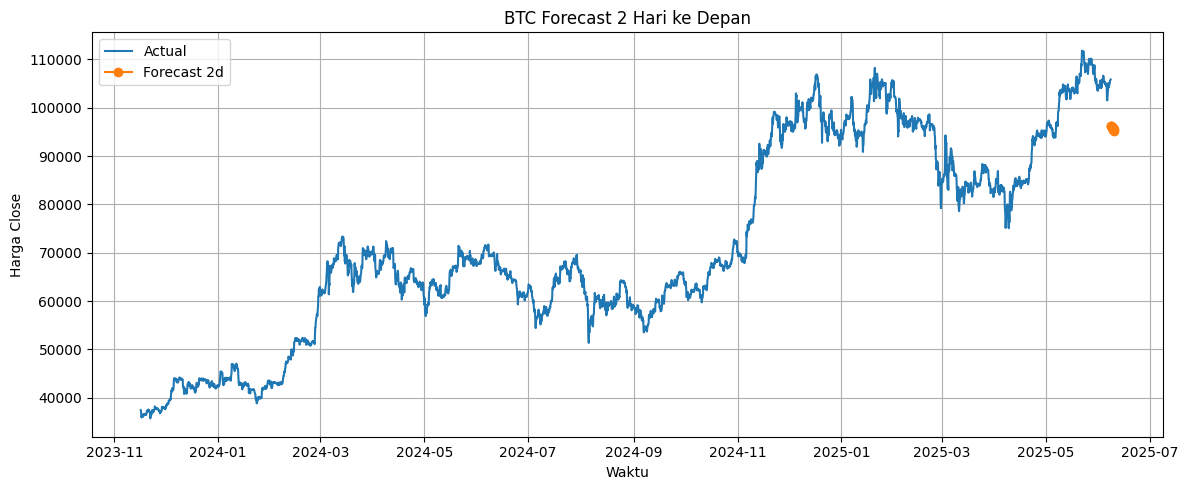

In [15]:
last_seq = test_vals[-SEQ_LEN:].reshape(1, SEQ_LEN, len(BEST_FEATURES))
fc_scaled = model_full.predict(last_seq)[0]
dummy = np.zeros((horizon, len(BEST_FEATURES)))
dummy[:, BEST_FEATURES.index('close')] = fc_scaled
fc_inv = scaler.inverse_transform(dummy)[:, BEST_FEATURES.index('close')]
idx_fc = [test_raw.index[-1] + interval * (i + 1) for i in range(horizon)]

plt.figure(figsize=(12, 5))
plt.plot(test_raw.index, test_raw['close'], label='Actual')
plt.plot(idx_fc, fc_inv, marker='o', linestyle='-', label=f'Forecast {FORECAST_DAYS}d')
plt.title(f'BTC Forecast {FORECAST_DAYS} Hari ke Depan')
plt.xlabel('Waktu')
plt.ylabel('Harga Close')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('forecast_bestf.png')
plt.show()